## Background

House price has always been an serious social issue in Taiwan, especially in Taipei city. The nation-wide house price to income ratio revealed by Taiwanese government is around 8.62 in 2020(**[1]**). For Taipei city is around 14.39. If we compare these values with Demographia International Housing Affordability Survey 2019(**[2]**), it's not hard to realize that this such a high number. 

Therefore, I would like to build a regression model trying to predict the housing price in Taipei city, the capital city of Taiwan. Not only to predict the housing price, I also would like to find out what affect housing price the most influentially. Hope the analysis could give us some insight into the cause of present house price problem in Taiwan.

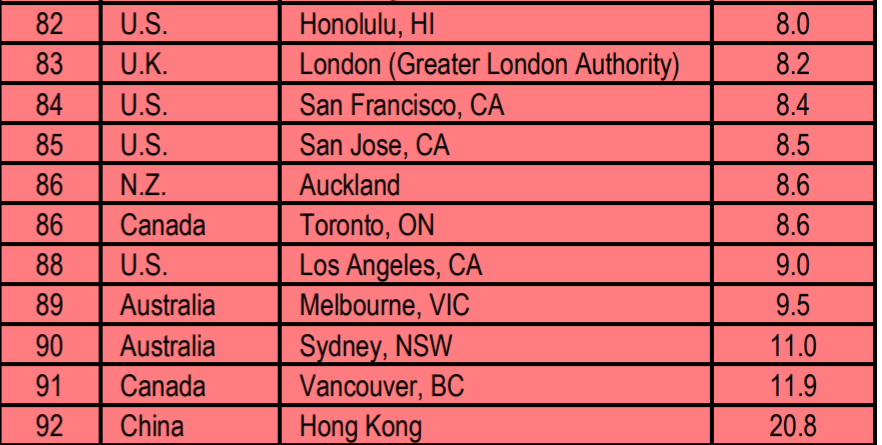

## About Dataset

 This dataset is downloaded from Kaggle(**[3]**). This dataset contains some useful information about recent real estate transaction in Taipei city, the original data mainly comes from open data of Ministry of the Interior of Taiwan(**[4]**).

### Import Libraries
Before importing our dataset of desired, we have to import necessary Python modules

In [1030]:
import pandas as pd
import numpy as np
import csv 
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
pd.options.display.max_columns = 50
%matplotlib inline

### Import Dataset
Now let's import our dataset and check the first few rows with head method.

In [1031]:
#We import dataset as "Resident_Dataset" which we already filtered out other data not for resident use.
Resident_Dataset = pd.read_csv('2020_H2_Resident_ENG.csv')
Shape = Resident_Dataset.shape

#Let's see how the dataset looks like
Resident_Dataset.head()

,district,transaction type,land shifting total area,transaction year,num_building,num_land,num_garage,total floor number,building state,main building materials,complete year,building shifting total area,num_room,num_bathroom,compartment,management org,carpark type,carpark shifting area,carpark total price,main building area,subsidiary building area,balcony area,elevator,total ntd,unit ntd
0,Wenshan District,Land+Building,1261.30,108,1,3,0,1.0,House,Reinforced Concrete,NaN,245.48,0,0,0,0,No carpark,0.0,0,245.48,0.00,0.00,0,523060000,2130764
1,ZhongZheng District,Land+Building,36.00,109,1,2,0,5.0,Apartment_5storey,Reinforced Concrete,76.0,142.01,3,2,1,0,No carpark,0.0,0,106.57,4.81,16.47,0,18500000,130273
2,ZhongZheng District,Land+Building,19.39,109,1,2,0,7.0,Apartment_5to10storey,Reinforced Concrete,102.0,84.97,2,1,1,0,No carpark,0.0,0,50.17,0.00,5.05,1,21580000,253972
3,ZhongZheng District,Land+Building,10.66,109,1,1,0,5.0,Apartment_5storey,Strengthened Brickwork,NaN,34.63,0,1,1,0,No carpark,0.0,0,33.00,1.63,0.00,0,10400000,300318
4,ZhongZheng District,Land+Building,45.00,109,1,1,0,4.0,Apartment_5storey,Strengthened Brickwork,58.0,99.86,3,2,1,0,No carpark,0.0,0,99.86,0.00,0.00,0,35800000,358502


## Data Cleaning and Feature Engineering

### Data Transformation
In this cell, we transform some of the column into quantity per unit land or building.

Also, we do some feature engineering to create some new features for later analysis.

In [1032]:
#We do not take transaction data with 0 room into consideration
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_room"]!=0]

# This part average land shifting total area with number of land transaction.
Resident_Dataset["land shifting total area per unit transaction"] = Resident_Dataset["land shifting total area"]/Resident_Dataset["num_land"]
Resident_Dataset["land shifting total area per unit transaction"].replace(np.inf, np.nan, inplace = True)
Resident_Dataset["land shifting total area per unit transaction"].fillna(0,inplace = True)

# This part average building shifting total area with number of building transaction.
Resident_Dataset["building shifting total area per unit transaction"] = Resident_Dataset["building shifting total area"]/Resident_Dataset["num_building"]

#This part average some other columns with number of building
Resident_Dataset["num_room"] = Resident_Dataset["num_room"]/Resident_Dataset["num_building"]
Resident_Dataset["num_bathroom"] = Resident_Dataset["num_bathroom"]/Resident_Dataset["num_building"]
Resident_Dataset["main building area"] = Resident_Dataset["main building area"]/Resident_Dataset["num_building"]
Resident_Dataset["balcony area"] = Resident_Dataset["balcony area"]/Resident_Dataset["num_building"]
Resident_Dataset["subsidiary building area"] = Resident_Dataset["subsidiary building area"]/Resident_Dataset["num_building"]

#This part adds some derived feature to the dataset
#This line create total shifting area per unit transaction
Resident_Dataset["total shifting area per unit transaction"] = Resident_Dataset["land shifting total area per unit transaction"] + Resident_Dataset["building shifting total area per unit transaction"]

#This line create building age at transaction
Resident_Dataset["building age at transaction"] = Resident_Dataset['transaction year'] - Resident_Dataset['complete year']

#This line create main building ratio by taking main building area over building shifting total area
Resident_Dataset["main building ratio"] = Resident_Dataset["main building area"]/Resident_Dataset["building shifting total area"]

#This line create unit price without carpark price included
Resident_Dataset["unit ntd nocarpark"] = (Resident_Dataset["total ntd"] - Resident_Dataset["carpark total price"])/Resident_Dataset["building shifting total area"]

#Resident_Dataset[Resident_Dataset["building age at transaction"] < 0 ] = 0

#Finally, we drop some columns that is no longer of our interest
Resident_Dataset.drop(columns=["carpark total price","num_garage","carpark shifting area","carpark type","land shifting total area","building shifting total area","num_land","num_building","transaction year","complete year","total ntd","unit ntd"], inplace = True)
Resident_Dataset.head()

,district,transaction type,total floor number,building state,main building materials,num_room,num_bathroom,compartment,management org,main building area,subsidiary building area,balcony area,elevator,land shifting total area per unit transaction,building shifting total area per unit transaction,total shifting area per unit transaction,building age at transaction,main building ratio,unit ntd nocarpark
1,ZhongZheng District,Land+Building,5.0,Apartment_5storey,Reinforced Concrete,3.0,2.0,1,0,106.57,4.81,16.47,0,18.000,142.01,160.010,33.0,0.750440,130272.516020
2,ZhongZheng District,Land+Building,7.0,Apartment_5to10storey,Reinforced Concrete,2.0,1.0,1,0,50.17,0.00,5.05,1,9.695,84.97,94.665,7.0,0.590444,253971.990114
4,ZhongZheng District,Land+Building,4.0,Apartment_5storey,Strengthened Brickwork,3.0,2.0,1,0,99.86,0.00,0.00,0,45.000,99.86,144.860,51.0,1.000000,358501.902664
6,Wanhua District,Land+Building+Garage,24.0,Apartment_11storeyorgreater,Reinforced Concrete,1.0,1.0,1,1,33.95,3.15,3.22,1,4.460,97.18,101.640,1.0,0.349352,122967.688825
7,Wanhua District,Land+Building+Garage,24.0,Apartment_11storeyorgreater,Reinforced Concrete,2.0,1.0,1,1,35.45,2.61,3.75,1,4.570,75.59,80.160,1.0,0.468977,160074.083874


This cell filters our features with abnormally high quantity of rooms and bathrooms. (7 per unit building transaction in our case)

In [1033]:
#According to common sense, it is abnormal for a single building to have more than 6 rooms and bathrooms
#Thus we filter out data not within this range.
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_room"] <= 7]
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_bathroom"] <= 7]

### Checking Duplicates
In this cell, we check if there are duplicated rows and found that there are 44 duplicated rows

In [1034]:
#We use duplicated method to find out duplicated rows and print our results
num_duplicated = sum(Resident_Dataset.duplicated(keep = "first"))
print("There are " + str(num_duplicated) + " duplicated rows in this dataset")

#Then, we update our dataset to no duplicate one
Resident_Dataset = Resident_Dataset[~Resident_Dataset.duplicated(keep = "first")]
display(Resident_Dataset.head())

#Check again to see if there are duplicates
num_duplicated = sum(Resident_Dataset.duplicated(keep = "first"))
print("There are " + str(num_duplicated) + " duplicated rows in this dataset after cleaning")

There are 44 duplicated rows in this dataset


,district,transaction type,total floor number,building state,main building materials,num_room,num_bathroom,compartment,management org,main building area,subsidiary building area,balcony area,elevator,land shifting total area per unit transaction,building shifting total area per unit transaction,total shifting area per unit transaction,building age at transaction,main building ratio,unit ntd nocarpark
1,ZhongZheng District,Land+Building,5.0,Apartment_5storey,Reinforced Concrete,3.0,2.0,1,0,106.57,4.81,16.47,0,18.000,142.01,160.010,33.0,0.750440,130272.516020
2,ZhongZheng District,Land+Building,7.0,Apartment_5to10storey,Reinforced Concrete,2.0,1.0,1,0,50.17,0.00,5.05,1,9.695,84.97,94.665,7.0,0.590444,253971.990114
4,ZhongZheng District,Land+Building,4.0,Apartment_5storey,Strengthened Brickwork,3.0,2.0,1,0,99.86,0.00,0.00,0,45.000,99.86,144.860,51.0,1.000000,358501.902664
6,Wanhua District,Land+Building+Garage,24.0,Apartment_11storeyorgreater,Reinforced Concrete,1.0,1.0,1,1,33.95,3.15,3.22,1,4.460,97.18,101.640,1.0,0.349352,122967.688825
7,Wanhua District,Land+Building+Garage,24.0,Apartment_11storeyorgreater,Reinforced Concrete,2.0,1.0,1,1,35.45,2.61,3.75,1,4.570,75.59,80.160,1.0,0.468977,160074.083874


There are 0 duplicated rows in this dataset after cleaning


### Checking and Removing NAN
Result shows there are only 3 columns are with NaN or Null value, and proportion of it are all less than 1%

In [1035]:
#We build a dataframe to exhibit the percentage of NaN or Null value 
NAN_Rate = pd.DataFrame(data={"% of NAN":Resident_Dataset.isna().sum()/Shape[0]})
NAN_Rate[NAN_Rate["% of NAN"]!=0]

,% of NAN
total floor number,0.001427
main building materials,0.000204
building age at transaction,0.058698


Subsequently, we remove those rows with NaN or Null since it only occupies less than 1 % of the dataset

In [1036]:
for cols in list(Resident_Dataset.columns):
    Resident_Dataset = Resident_Dataset[~Resident_Dataset[cols].isna()]

print("Shape of Resident_Dataset is now " + str(Resident_Dataset.shape))

Shape of Resident_Dataset is now (8451, 19)


### Distribution of Numerical Variables

First extract numerical columns from original dataset based on column data type. In this step, we also abandoned some numerical columns that is considered discrete and non-quatitative variable. There are 12 different numerical features in our dataset. 

In [1037]:
#We create a table listing data types of all columns 
#and pick up numerical ones based on their data type
Type_Table = pd.DataFrame(data={"dtype":Resident_Dataset.dtypes})
Numerical_Columns = list(Type_Table[Type_Table["dtype"] != "object"].index)

#Remove column management_org in numerical cloumns because it's dummy variable type numerical
#Remove transaction year,month and complete year because they are discrete and non-quatitative variables
try:
    Numerical_Columns.remove("management org")
    Numerical_Columns.remove("elevator")
    Numerical_Columns.remove("unit ntd nocarpark")
    Numerical_Columns.remove("compartment")
except:
    pass

#Report results of numerical columns
print("We have " + str(len(Numerical_Columns))+" numerical features.")
print("Numerical Columns are :\n" + str(Numerical_Columns))

We have 11 numerical features.
Numerical Columns are :
['total floor number', 'num_room', 'num_bathroom', 'main building area', 'subsidiary building area', 'balcony area', 'land shifting total area per unit transaction', 'building shifting total area per unit transaction', 'total shifting area per unit transaction', 'building age at transaction', 'main building ratio']


Second, we visualize the distribution of numerical variables using histogram. You can see there are a lot of right skewed distribution.

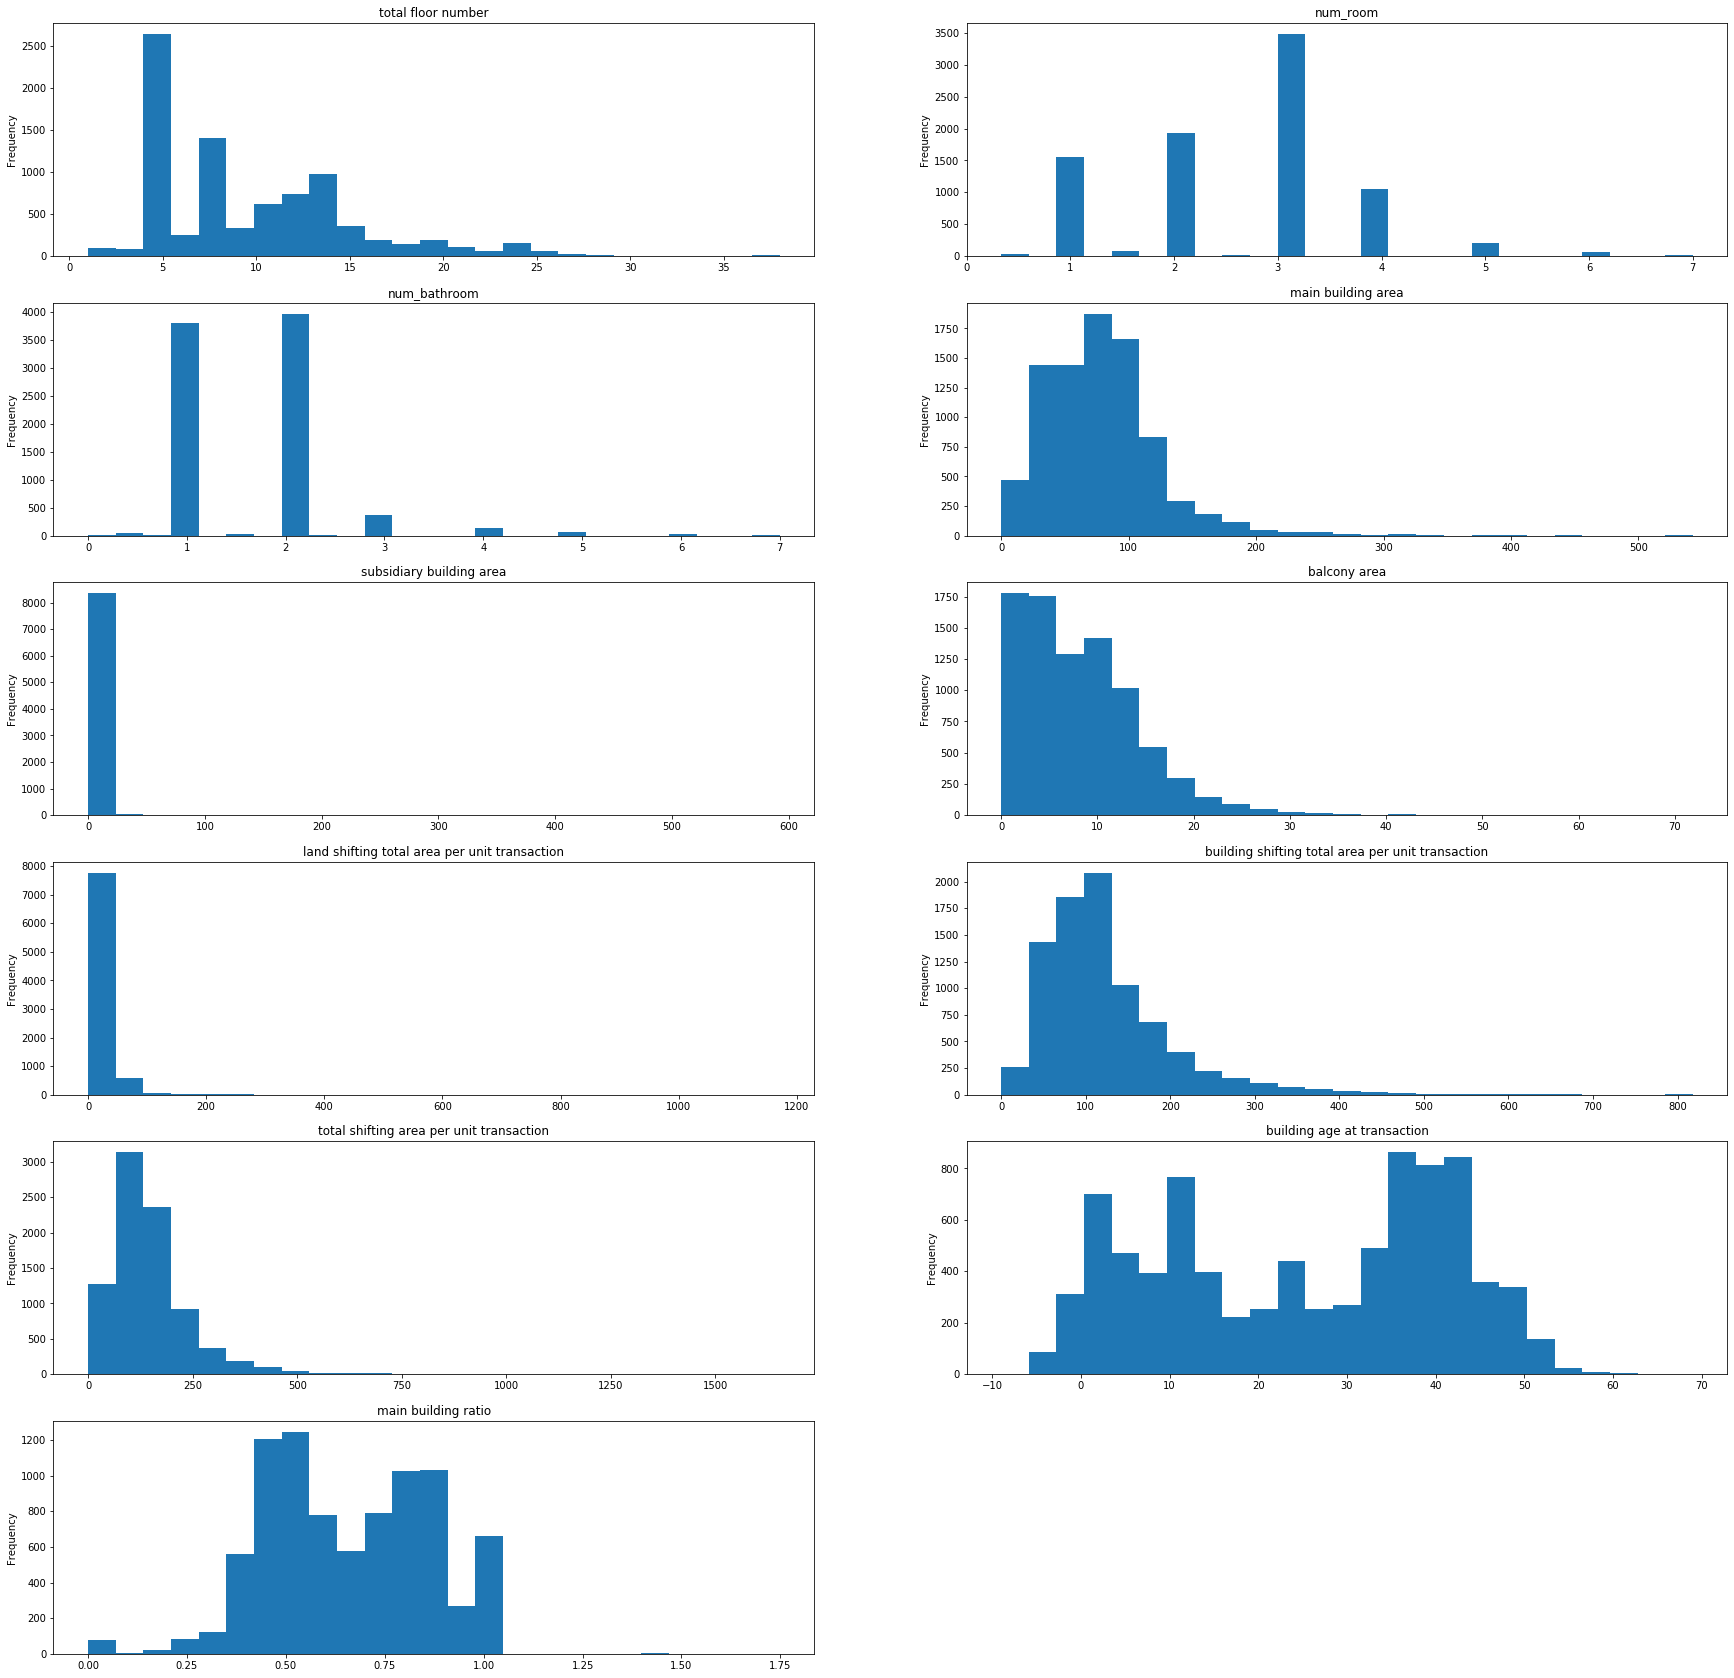

In [1038]:
fig = plt.figure(figsize = [30,30])
sub_ind = 1
for cols in Numerical_Columns:
    Resident_Dataset[cols].plot.hist(ax = plt.subplot(6,2,sub_ind), bins =25, title = cols)
    sub_ind += 1

### Statistics of Numerical Variable and Outlier (More like extreme values) Rejection
This cell creates a  statistical table listing 1.5IQR information. We will reference the table to eliminate data points that is not considered normal condition at all.

In [1039]:
Num_Max = []
Num_min = []
mean_lst = []
stdlist = []
stdup = []
stdlow = []
IQRup = []
IQRlow = []
for cols in Numerical_Columns:
    mean = Resident_Dataset[cols].mean()
    std = Resident_Dataset[cols].std()
    Q1 = Resident_Dataset[cols].quantile(0.25)
    Q3 = Resident_Dataset[cols].quantile(0.75)
    mean_lst.append(mean)
    stdlist.append(std)
    stdup.append(mean + 3*std)
    stdlow.append(mean - 3*std)
    IQR = Q3 - Q1
    Num_Max.append(Resident_Dataset[cols].max())
    Num_min.append(Resident_Dataset[cols].min())
    IQRup.append(Q3 + 1.5*IQR)
    IQRlow.append(Q1 - 1.5*IQR)

Numerical_Columns_Stats = pd.DataFrame({"Feature":Numerical_Columns,"Max":Num_Max,"min":Num_min,"Mean":mean_lst,"std":stdlist ,"IQRup":IQRup,"IQRlow":IQRlow})#,"stdup":stdup,"stdlow":stdlow})
Numerical_Columns_Stats.index = Numerical_Columns_Stats["Feature"]
Numerical_Columns_Stats.drop(columns = ["Feature"], inplace = True)
Numerical_Columns_Stats

,Max,min,Mean,std,IQRup,IQRlow
Feature,,,,,,
total floor number,38.000000,1.000000,9.566915,5.389085,25.000000,-7.000000
num_room,7.000000,0.333333,2.586262,1.083912,4.500000,0.500000
num_bathroom,7.000000,0.000000,1.648227,0.758358,3.500000,-0.500000
main building area,542.670000,0.000000,78.155563,44.000474,179.922500,-34.257500
subsidiary building area,592.210000,0.000000,2.944844,9.789155,8.187500,-4.912500
balcony area,71.870000,0.000000,8.062736,6.487781,24.180000,-9.100000
land shifting total area per unit transaction,1171.000000,0.000000,23.692039,27.888085,62.283750,-22.286250
building shifting total area per unit transaction,818.030000,0.010000,124.324250,79.176000,270.792500,-43.067500
total shifting area per unit transaction,1654.010000,0.010000,148.016289,94.870654,314.123095,-43.760714


We scan through numerical rows and cut off data point with value greater than limitation defined by 1.5IQR method.

In [1040]:
#Define feature requiring cleaning
clean_columns = ["main building area", "subsidiary building area", "balcony area",\
                "land shifting total area per unit transaction", "building shifting total area per unit transaction",\
                 "total shifting area per unit transaction"]

#Iteratively clean the features
for cols in clean_columns:
    threshold = Numerical_Columns_Stats.loc[cols,"IQRup"]
    Resident_Dataset = Resident_Dataset[Resident_Dataset[cols] < threshold]

#Show the present shape of dataset 
Resident_Dataset.shape

(7095, 19)

In this cell, we further clean the dataset according to our prediction goal (unit ntd nocarpark). We would like to remove some extreme data of unit_ntd column because these values may not reflect normal housing transaction behavior compared to those inside our range of interest.

We will apply 1.5\*IQR method filter our data. After filtration, you can see the close to symmetry distribution of unit ntd nocarpark

Text(0.5, 1.0, 'Distribution of Unit ntd after cutting 2% data')

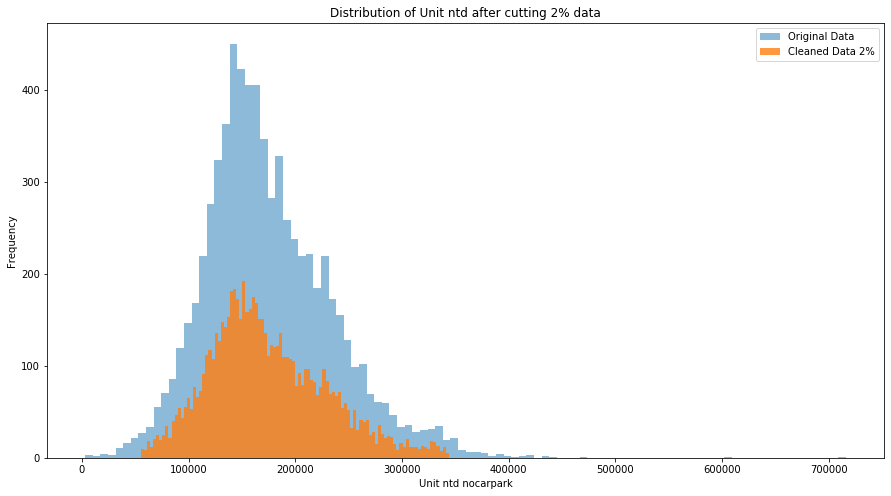

In [1041]:
#In order to get a more general model that can fit non-extreme cases,
#We will abandon first and last 1% of data after sorting with unit ntd.
old_unit_ntd = Resident_Dataset["unit ntd nocarpark"]
percent_1 = Resident_Dataset.shape[0]*0.01
Resident_Dataset = Resident_Dataset.sort_values(by=['unit ntd nocarpark']).iloc[int(percent_1):-int(percent_1),:]

#Plot to show distribution before and after cleaning dependent variable
plt.figure(figsize = [15,8])
plt.hist(old_unit_ntd, bins = 100,alpha=0.5)
plt.hist(Resident_Dataset["unit ntd nocarpark"], bins = 100, alpha = 0.8)
plt.xlabel("Unit ntd nocarpark")
plt.ylabel("Frequency")
plt.legend(["Original Data","Cleaned Data 2%"])
plt.title("Distribution of Unit ntd after cutting 2% data")


## Feature Selection
### Correlation Analysis
We first select features for our numerical dataset. Firstly, we import necessary libraries for later regression

In [1042]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

This cell creates table for numerical variables

In [1043]:
#Create numerical table
Numerical_Table = Resident_Dataset[Numerical_Columns]
Numerical_Table.head()

,total floor number,num_room,num_bathroom,main building area,subsidiary building area,balcony area,land shifting total area per unit transaction,building shifting total area per unit transaction,total shifting area per unit transaction,building age at transaction,main building ratio
2086,9.0,3.0,1.0,46.95,0.00,4.25,29.27,77.57,106.84,22.0,0.605260
6416,4.0,3.0,1.0,101.17,0.00,0.00,34.25,101.17,135.42,44.0,1.000000
3927,4.0,3.0,2.0,85.80,0.00,15.34,37.01,101.14,138.15,40.0,0.848329
7931,14.0,4.0,2.0,38.85,1.04,4.28,13.84,79.80,93.64,9.0,0.486842
1064,4.0,3.0,1.0,42.76,0.00,0.00,0.00,42.76,42.76,50.0,1.000000


This cell shows the correlation results of numerical features

,Correlation Coefficient
unit ntd nocarpark,1.000000
building age at transaction,0.278771
total floor number,0.268074
num_room,0.215221
land shifting total area per unit transaction,0.208603
main building ratio,0.194032
main building area,0.128079
subsidiary building area,0.097930
balcony area,0.097235
total shifting area per unit transaction,0.085342


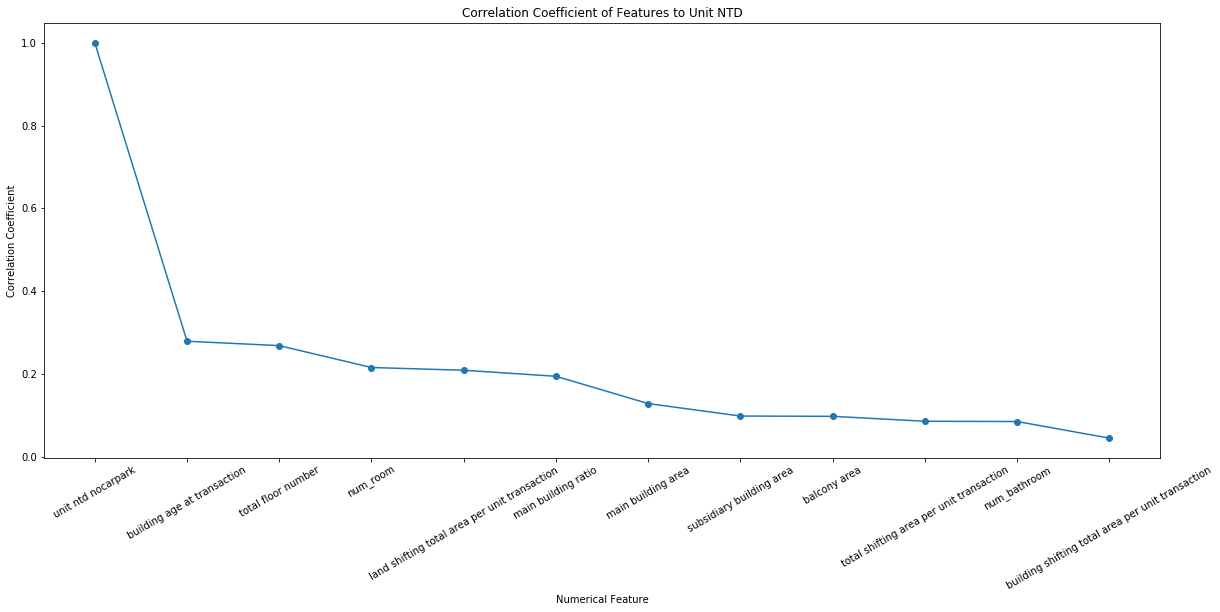

In [1044]:
Numerical_Table2 = pd.concat([Numerical_Table,Resident_Dataset["unit ntd nocarpark"]],axis=1)
Numerical_Corr = pd.DataFrame(abs(Numerical_Table2.corr()["unit ntd nocarpark"]))
Numerical_Corr.columns = ["Correlation Coefficient"]
Numerical_Corr.sort_values(by = "Correlation Coefficient", ascending = False, inplace = True)

display(Numerical_Corr)


plt.figure(figsize = [20,8])
plt.xticks(rotation = 30)
plt.xlabel("Numerical Feature")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Coefficient of Features to Unit NTD")
plt.plot(Numerical_Corr, marker = 'o') 

Numerical_Columns2 = list(Numerical_Corr[Numerical_Corr["Correlation Coefficient"]>0.15].index)
Numerical_Columns2.remove("unit ntd nocarpark")

del Numerical_Table2

### Unique Categories within Categorical Features
Before converting categorical features, we first briefly inspect the number of different categories in each categorical variable.

In [1016]:
Categorical_Unique = {"Categorical_Variable":[],"Unique_Values":[]}
Categorical_Columns = []
for cols in list(Resident_Dataset.columns):
    if cols not in Numerical_Columns and cols != "unit ntd nocarpark":
        Categorical_Columns.append(cols)
        Categorical_Unique["Categorical_Variable"].append(cols)
        Categorical_Unique["Unique_Values"].append(len(Resident_Dataset[cols].unique()))
Categorical_Unique_Table = pd.DataFrame(Categorical_Unique)
Categorical_Unique_Table

,Categorical_Variable,Unique_Values
0,district,12
1,transaction type,3
2,building state,8
3,main building materials,9
4,compartment,1
5,management org,2
6,elevator,2


### Creating Dummy Variables for Categorical Features
Before turning these variables into dummy variable, we look briefly at the number of unique labels within  the variable

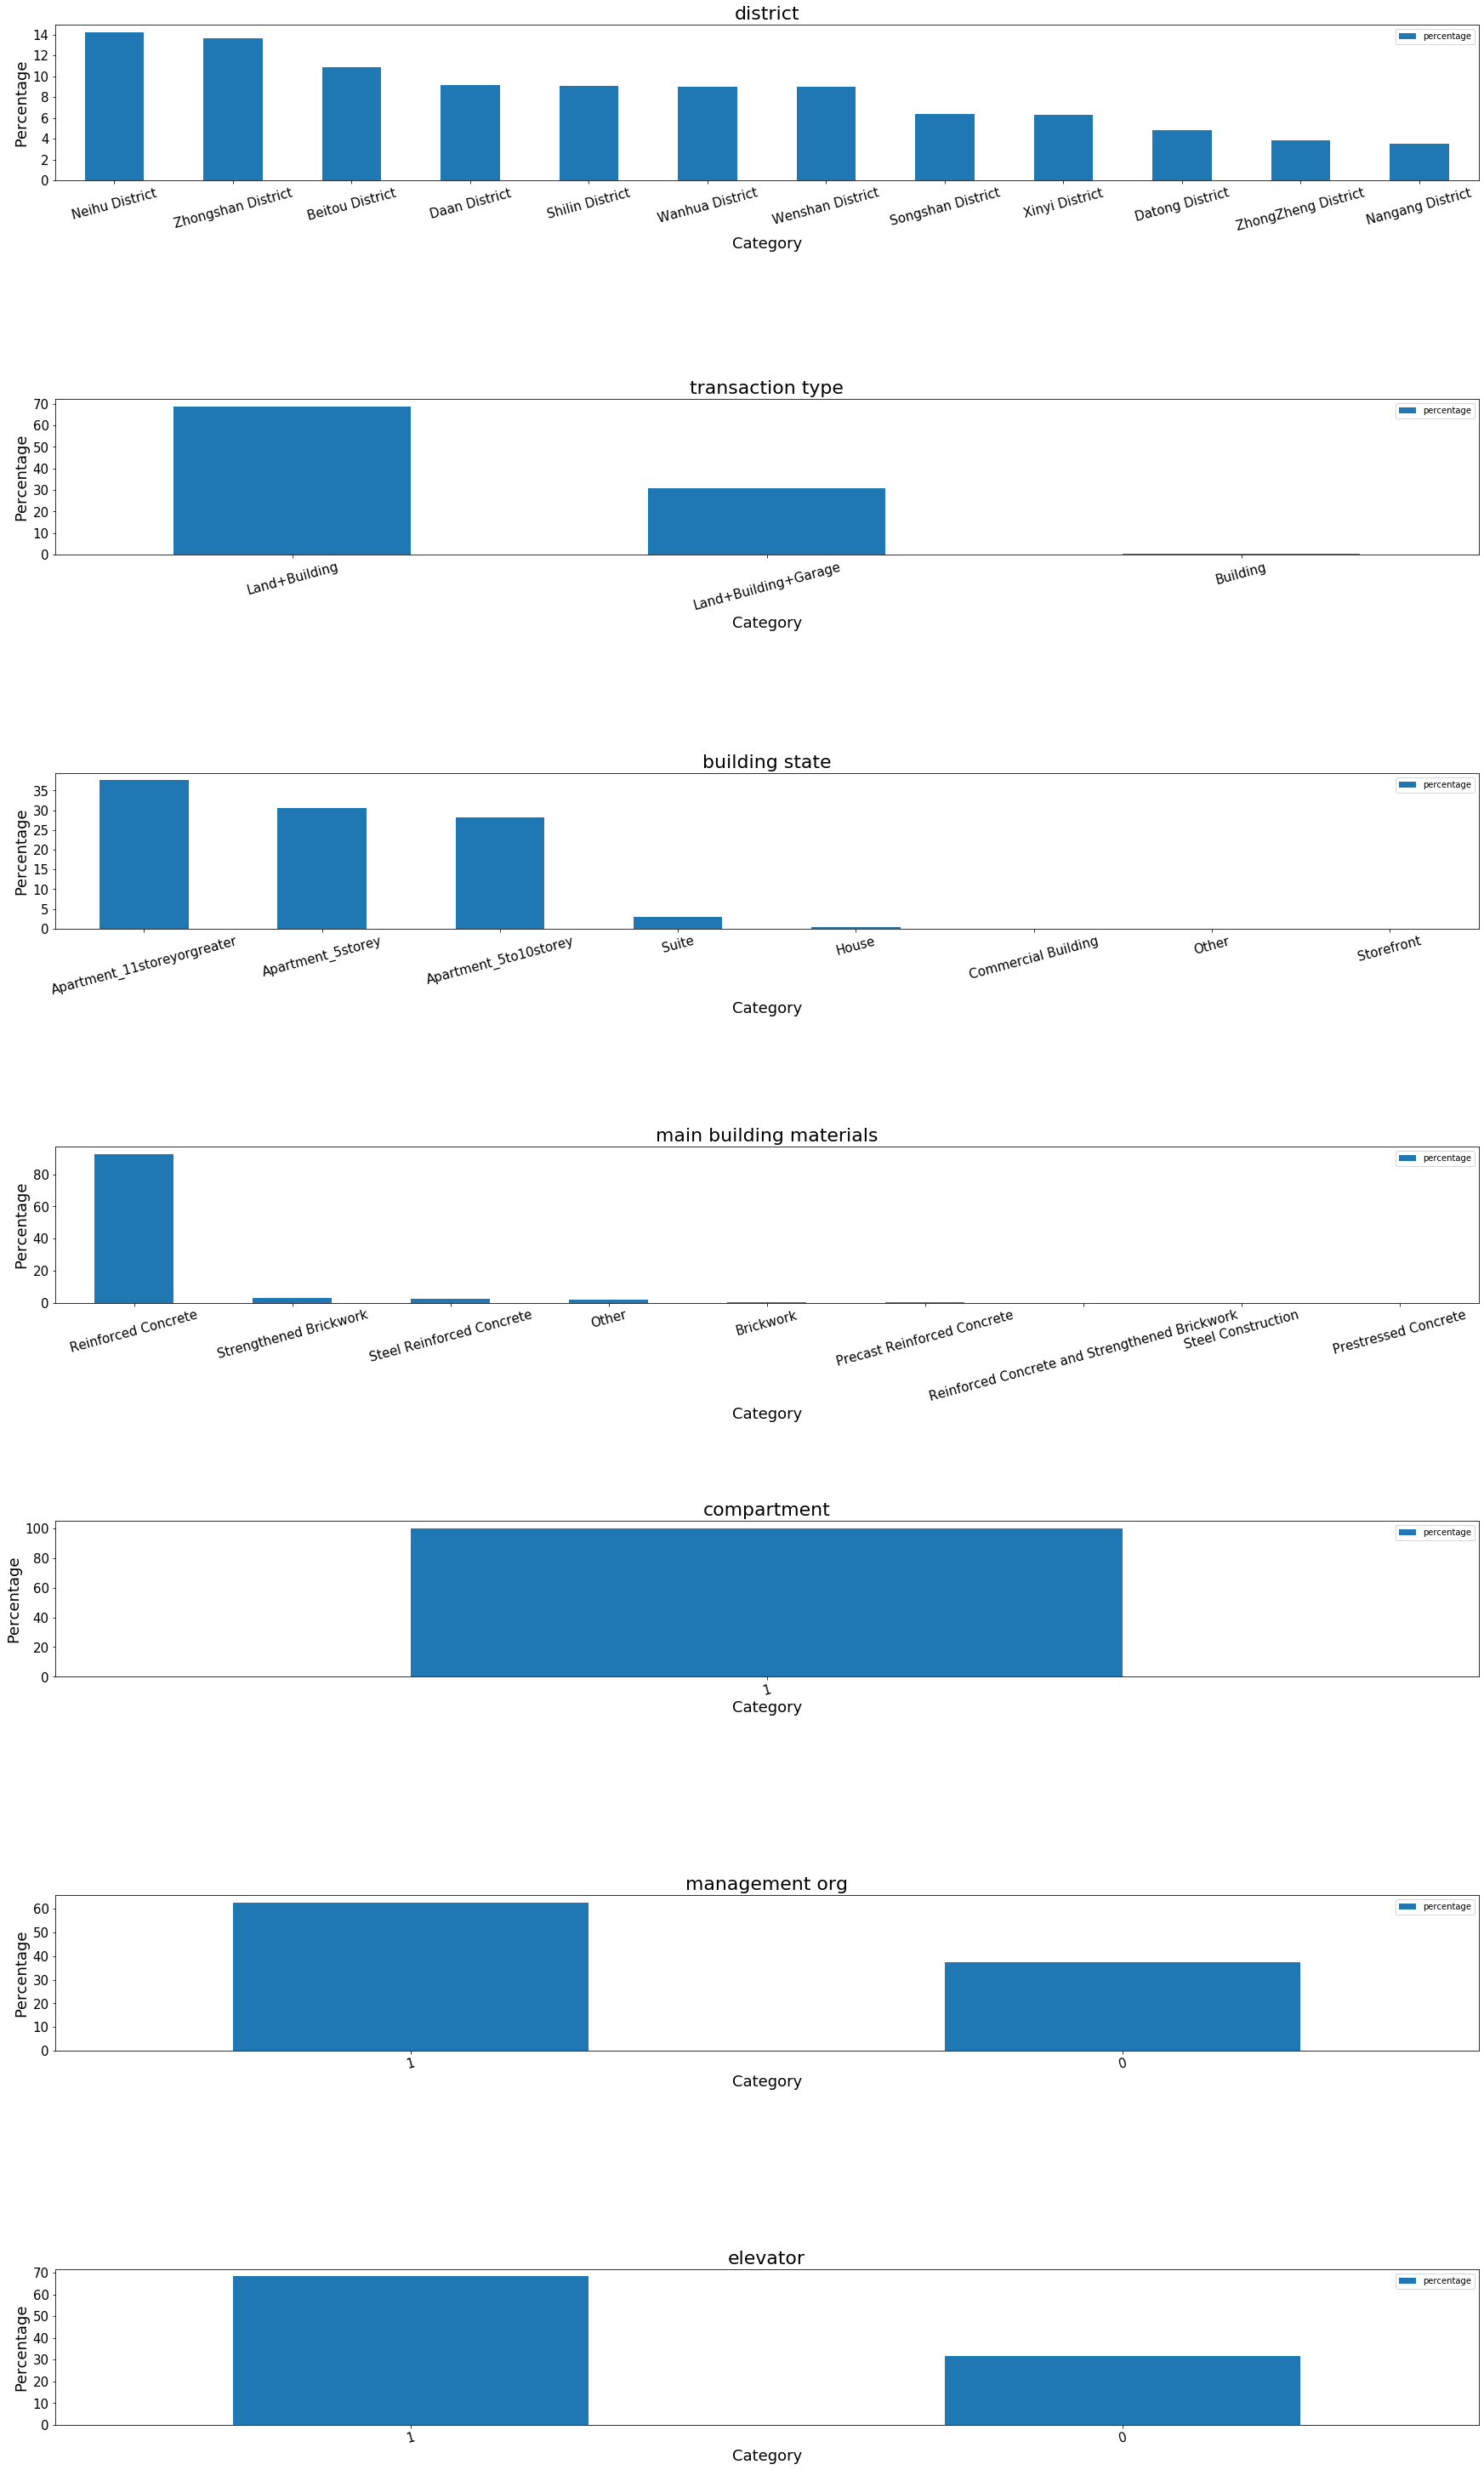

In [1017]:
data_num = Resident_Dataset.shape[0]
fig2,ax2 = plt.subplots(figsize = [30,60])   
ind = 1

Proportion_Dict = {}
   
for var in Categorical_Columns:
    Temp_DF = pd.DataFrame(Resident_Dataset[var].value_counts()).reset_index()
    Temp_DF.insert(0,"variable",[var]*Temp_DF.shape[0])
    Temp_DF.columns = ["variable","category","percentage"]
    Temp_DF["percentage"] = Temp_DF["percentage"]/data_num*100
    Temp_DF.set_index(["variable","category"],inplace=True)
    for cats in list(Resident_Dataset[var].unique()):
        if var not in Proportion_Dict.keys():
            Proportion_Dict[var] = {}
        Proportion_Dict[var][cats] = Temp_DF.loc[var,cats]
        
    Temp_DF.loc[var].plot(kind="bar", ax = plt.subplot(15,1,ind),title=var,fontsize=15)
    plt.xticks(rotation=15)
    plt.xlabel("Category",fontsize = 18)
    plt.ylabel("Percentage",fontsize = 18)
    plt.title(var,fontsize=22)
    ind+=2


### Meaningless Feature Rejection
In this cell, we will do some feature engineering on categories in features having too few samples. Because this kind of transformation cannot provide effective behavior and may harm the regression algorithm  

In [1018]:
#In this cell, we will do some feature engineering on categories in features having too few samples. 
#Because this kind of transformation cannot provide effective behavior and may harm the regression 
#algorithm  

#Create a new dataset to store data for later regression
Categorical_Dataset = pd.DataFrame()

#For feature transaction_type, we will omit the category "building" and "garage" because they 
#occupied only a very minor part. Also, the concept of these two types are as well exhibited by 
#categories.
exclusion = ["management org","elevator","compartment"]
for var in Categorical_Columns:
    if var not in exclusion:
        Categorical_Dataset = pd.concat([Categorical_Dataset,pd.get_dummies(Resident_Dataset[var],prefix = var)], axis = 1, sort = False)
        for cats in Proportion_Dict[var].keys():
            value = float(Proportion_Dict[var][cats])
            if value < 1:
                Categorical_Dataset.drop(columns = [str(var) + "_" + str(cats)], inplace = True)
    else:
        Categorical_Dataset[var] = Resident_Dataset[var]
        
#Drop some other columns
Categorical_Dataset.drop(columns=["compartment","main building materials_Other"],inplace=True)   
Categorical_Dataset

,district_Beitou District,district_Daan District,district_Datong District,district_Nangang District,district_Neihu District,district_Shilin District,district_Songshan District,district_Wanhua District,district_Wenshan District,district_Xinyi District,district_ZhongZheng District,district_Zhongshan District,transaction type_Land+Building,transaction type_Land+Building+Garage,building state_Apartment_11storeyorgreater,building state_Apartment_5storey,building state_Apartment_5to10storey,building state_Suite,main building materials_Reinforced Concrete,main building materials_Steel Reinforced Concrete,main building materials_Strengthened Brickwork,management org,elevator
2086,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1
6416,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
3927,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
7931,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1
1064,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1
3107,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1
8997,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,1
3971,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1


### Create Final Dataset
Finally, we concatenate categorical and numerical dataset as our final dataset for regression

In [1019]:
Dataset = pd.concat([Categorical_Dataset,Resident_Dataset[Numerical_Columns2]], axis = 1)
Dataset.head(5)

,district_Beitou District,district_Daan District,district_Datong District,district_Nangang District,district_Neihu District,district_Shilin District,district_Songshan District,district_Wanhua District,district_Wenshan District,district_Xinyi District,district_ZhongZheng District,district_Zhongshan District,transaction type_Land+Building,transaction type_Land+Building+Garage,building state_Apartment_11storeyorgreater,building state_Apartment_5storey,building state_Apartment_5to10storey,building state_Suite,main building materials_Reinforced Concrete,main building materials_Steel Reinforced Concrete,main building materials_Strengthened Brickwork,management org,elevator,building age at transaction,total floor number,num_room,land shifting total area per unit transaction,main building ratio
2086,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,22.0,9.0,3.0,29.27,0.605260
6416,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,44.0,4.0,3.0,34.25,1.000000
3927,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,40.0,4.0,3.0,37.01,0.848329
7931,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,9.0,14.0,4.0,13.84,0.486842
1064,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,50.0,4.0,3.0,0.00,1.000000


## Regression
### OLS Fitting
We first divide our dataset into training and test set using train_test_split method in Scikit-Learn. Then, we apply Ordinary Least Square (OLS) method in statsmodel.api module to build the model

In [1020]:
#import statsmodel.api module
import statsmodels.api as sm
from  sklearn.metrics import r2_score

#Adding intercept term for dataset
Dataset["intercept"] = 1

#Divide whole dataset into x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(Dataset,Resident_Dataset["unit ntd nocarpark"],test_size = 0.3,random_state = 0)

#Fit the data with ordinary least square method
LR_OLS = sm.OLS(y_train, x_train)
LR_OLS_result = LR_OLS.fit()
display(LR_OLS_result.summary())
print("The Root Mean Square Error of this regression from test set is " + str(np.sqrt(mean_squared_error(LR_OLS_result.predict(x_test),y_test))))

#We try to remove data column with relatively high p value to see if we can get better result(threshold 0.01)
P_table = pd.DataFrame(LR_OLS_result.pvalues)
P_table.columns = ["P value"]
Dataset = Dataset[P_table[P_table["P value"]<0.05].index]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     unit ntd nocarpark   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     212.9
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        01:35:22   Log-Likelihood:                -58124.
No. Observations:                4868   AIC:                         1.163e+05
Df Residuals:                    4840   BIC:                         1.165e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
district_Beitou District                          -2.551e+04   1955.382    -13.048      0.000   -2.93e+04   -2.17e+04
district_Daan District                             7.721e+04   2136.893     36.131      0.000     7.3e+04    8.14e+04
district_Datong District                            915.7043   2671.909      0.343      0.732   -4322.452    6153.860
district_Nangang District                          6168.3523   2974.900      2.073      0.038     336.196     1.2e+04
district_Neihu District                            -197.7400   1798.569     -0.110      0.912   -3723.752    3328.272
district_Shilin District                           4430.8587   2100.477      2.109      0.035     312.970    8548.748
district_Songshan District                         5.269e+04   2324.578     22.665      0.000    4.81e+04    5.72e+04
district_Wanhua District                          -3.209e+04   2080.515    -15.424      0.000   -3.62e+04    -2.8e+04
district_Wenshan District                         -2.484e+04   2082.951    -11.923      0.000   -2.89e+04   -2.08e+04
district_Xinyi District                            3.555e+04   2291.222     15.514      0.000    3.11e+04       4e+04
district_ZhongZheng District                       4.562e+04   2841.884     16.052      0.000       4e+04    5.12e+04
district_Zhongshan District                        2.388e+04   1827.816     13.067      0.000    2.03e+04    2.75e+04
transaction type_Land+Building                     7.724e+04   1.13e+04      6.841      0.000    5.51e+04    9.94e+04
transaction type_Land+Building+Garage               5.57e+04   1.14e+04      4.896      0.000    3.34e+04     7.8e+04
building state_Apartment_11storeyorgreater        -2.885e+04   9784.146     -2.948      0.003    -4.8e+04   -9664.804
building state_Apartment_5storey                  -4.576e+04   7344.388     -6.230      0.000   -6.02e+04   -3.14e+04
building state_Apartment_5to10storey              -2.767e+04   9712.422     -2.849      0.004   -4.67e+04   -8632.258
building state_Suite                               -3.25e+04   9610.958     -3.381      0.001   -5.13e+04   -1.37e+04
main building materials_Reinforced Concrete       -1.676e+04   3918.312     -4.278      0.000   -2.44e+04   -9080.371
main building materials_Steel Reinforced Concrete  5524.0515   5036.683      1.097      0.273   -4350.135    1.54e+04
main building materials_Strengthened Brickwork     1.032e+04   5359.118      1.925      0.054    -187.343    2.08e+04
management org                                     2349.6731   1866.886      1.259      0.208   -1310.272    6009.618
elevator                                          -2634.6260   7582.366     -0.347      0.728   -1.75e+04    1.22e+04
building age at

The Root Mean Square Error of this regression from test set is 36605.42580069865


### Variance_Inflation_Factor Analysis (Reduce Collinearity)
From the information carried out by the summary of OLS fitting, there may be strong collinearity problem in our model. Thus, we perform variance_inflation_factor analysis to make sure that all VIF value of our features are below 10 (typical value indicating no serious collinearity issue)


In [1021]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#We will abandon features with relatively lower magnitude of coefficient because it indicates less
#influential to the model. But we have to normalize the magnitude first by multiplying span of the 
#feature so that we can get a more fair result.
normalize_factor = []
Coef = LR_OLS_result.params[Dataset.columns]
for cols in list(Dataset.columns):
    Maxval = Dataset[cols].max()
    minval = Dataset[cols].min()
    if Maxval-minval == 1:
        normalize_factor.append(1)
    else:
        normalize_factor.append(Maxval-minval)
        
#Create new coefficient after multiplying span of the feature
Coef = Coef*normalize_factor

#Remove intercept in our analysis
column = list(Dataset.columns)
column.remove("intercept")   
Temp_Dataset = Dataset[column]
abandoned_VIF = []

#Iterate until all VIFs are less than 10(typical value)
VIF_safe = False

#Run the while loop until all VIF is below 10
while VIF_safe == False:
    #Create dataframe for real time analysis 
    vif_table = pd.DataFrame()
    vif_table["Features"] = column
    vif_table["VIF"] = [variance_inflation_factor(Temp_Dataset.values, i) for i in range(Temp_Dataset.shape[1])]

    #Handle inf values
    if sum(vif_table["VIF"] == np.inf) > 0:
        column.remove(list(vif_table[vif_table["VIF"] == np.inf]["Features"])[0])
        Temp_Dataset = Temp_Dataset[column]
        
    #Handle VIF greater than 10
    elif sum(vif_table["VIF"] > 10) > 0:
        over10features = vif_table[vif_table["VIF"]>10]["Features"]
        Params = pd.DataFrame(abs(Coef[over10features]),columns = ["VIF"])
        Params.sort_values(by = "VIF", inplace = True)
        column.remove(Params.iloc[0,:].name)
        Temp_Dataset = Temp_Dataset[column]
        abandoned_VIF.append(Params.iloc[0,:].name)
        
    #All VIFs are less than 10, set VIF_safe = True
    else: 
        VIF_safe = True
    
#delete Temp_Numerical_Table
del Temp_Dataset

#Assign numerical columns to the result after VIF analysis
Dataset = Dataset[column]

display(vif_table)
print("Abandoned features are " + str(abandoned_VIF))

,Features,VIF
0,district_Beitou District,1.446926
1,district_Daan District,1.435405
2,district_Nangang District,1.142958
3,district_Shilin District,1.429479
4,district_Songshan District,1.345546
5,district_Wanhua District,1.361491
6,district_Wenshan District,1.376447
7,district_Xinyi District,1.300256
8,district_ZhongZheng District,1.151410
9,district_Zhongshan District,1.578689


Abandoned features are ['main building materials_Reinforced Concrete', 'building state_Apartment_5to10storey', 'main building ratio', 'transaction type_Land+Building']


This cell plots the final VIF of each features that were chosen.

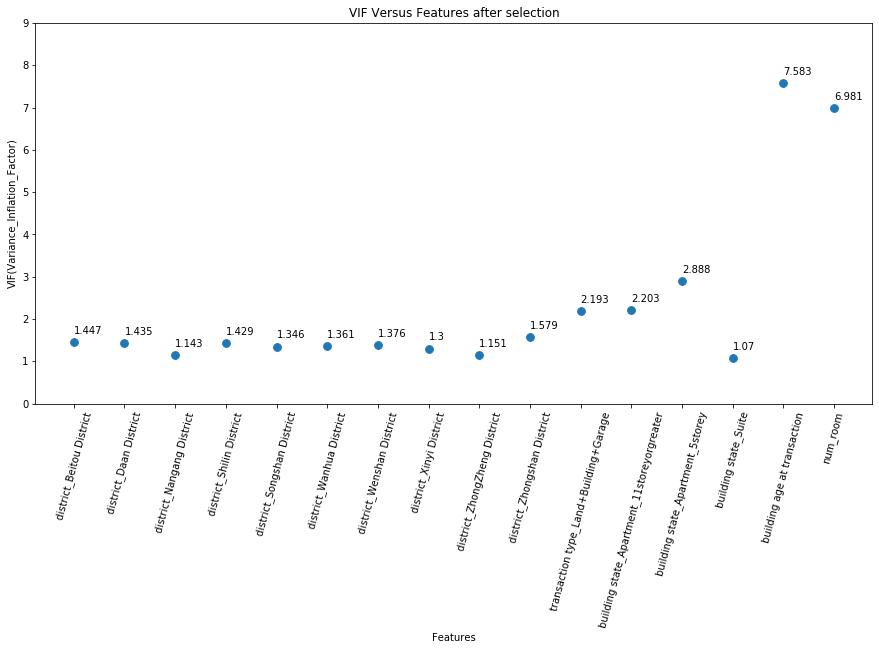

In [1022]:
fig0, ax0 = plt.subplots(figsize = [15,7])
ax0.set_ylim([0,9])
ax0.scatter(vif_table["Features"], vif_table["VIF"], s = 60)
ax0.set_xticklabels(list(vif_table["Features"]), rotation = 75)
ax0.set_xlabel("Features")
ax0.set_ylabel("VIF(Variance_Inflation_Factor)")
ax0.set_title("VIF Versus Features after selection")
for i in range(vif_table.shape[0]):
    fea = vif_table.iloc[i,0]
    val = round(vif_table.iloc[i,1],3)
    ax0.annotate(val,(fea,val+0.2))

### Iterative regression experiment
We carry on with 5 regressions with different random seed to see if the results are consistent. The dataframe Coef_Table was created to store coefficient results for those trials. Also, we create a new column to store the average value of those results, we will take this value as final results in later discussion. In the last part of this cell, we use a line plot to illustrate the coefficient results, the plot shows that we have a highly consistent and reproducible model.

,LR_OLS_R1_Coef,LR_OLS_R2_Coef,LR_OLS_R3_Coef,LR_OLS_R4_Coef,LR_OLS_R5_Coef,LR_OLS_AVG
district_Beitou District,-25148.418889,-21810.777980,-25930.836667,-23893.930355,-24088.254401,-24174.443658
district_Daan District,78310.045933,81161.863200,82071.985381,81529.325660,80224.117764,80659.467588
district_Nangang District,3806.599920,9042.914307,5706.486632,4571.003208,3156.904548,5256.781723
district_Shilin District,5631.465076,7694.636576,5411.558072,5234.101951,4592.167024,5712.785740
district_Songshan District,53442.470630,54424.783064,50941.478341,52644.103606,52378.749420,52766.317012
district_Wanhua District,-31628.676616,-29797.897304,-30776.215795,-30533.783502,-31335.128013,-30814.340246
district_Wenshan District,-25506.789419,-24655.187545,-26789.582570,-25001.461268,-26243.034151,-25639.210990
district_Xinyi District,37344.787673,37156.636041,38367.607975,34128.517824,36142.457332,36628.001369
district_ZhongZheng District,50761.597695,46087.622116,49897.436410,46836.745108,46936.104831,48103.901232
district_Zhongshan District,22412.279605,24831.029183,22268.191179,23661.600019,22850.272581,23204.674513


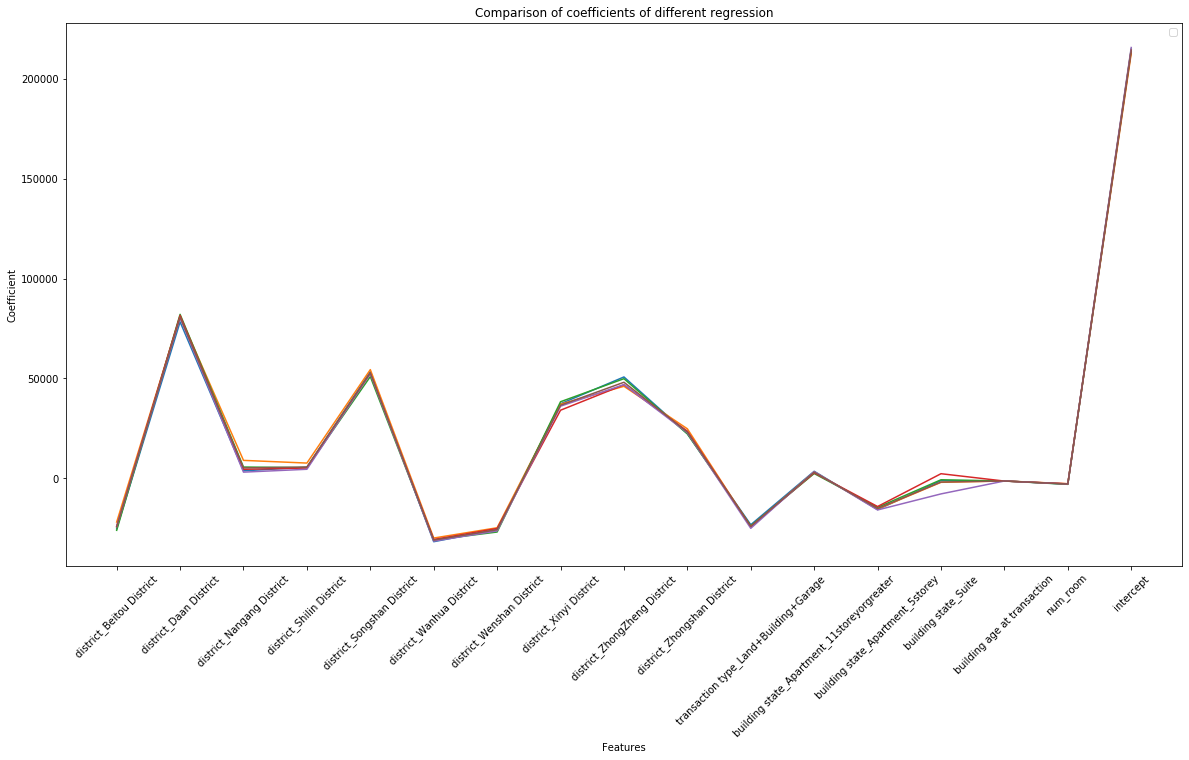

In [1023]:
#We create a metrics table to present the R square and root mean square metrics of our model
Metrics_Table = pd.DataFrame(index = ["LR_OLS_R1","LR_OLS_R2","LR_OLS_R3","LR_OLS_R4","LR_OLS_R5"],\
                             columns = ["R squared from training set", "RMSE from test set"])

Dataset["intercept"] = 1
Coef_Table = pd.DataFrame(index = list(Dataset.columns))

for i in range(1,6):
    x_train1, x_test1, y_train1, y_test1 = train_test_split(Dataset, Resident_Dataset["unit ntd nocarpark"], test_size=0.3, random_state = i)
    LR_OLS2 = sm.OLS(y_train1, x_train1)
    LR_OLS2_result = LR_OLS2.fit()
    Metrics_Table.loc["LR_OLS_R" + str(i), "R squared from training set"] = LR_OLS2_result.rsquared
    Metrics_Table.loc["LR_OLS_R" + str(i), "RMSE from test set"] = np.sqrt(mean_squared_error(LR_OLS2_result.predict(x_test1),y_test1))
    Coef_Table["LR_OLS_R" + str(i) + "_Coef"] = list(LR_OLS2_result.params)

#Calculate average coefficient value of five regressions    
Coef_Table["LR_OLS_AVG"] = Coef_Table.mean(axis = 1)

#We visualize the coefficient results with line plot
plt.figure(figsize=[20,10])
plt.xticks(rotation = 45)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Comparison of coefficients of different regression")
plt.legend(["center"])
plt.plot(Coef_Table, label = Coef_Table.columns)

display(Coef_Table)

### Metrics evaluation
This cell shows metrics table that stores results of our regression

In [1045]:
#Metrics table list the results of each iteration of regression
Metrics_Table

,R squared from training set,RMSE from test set
LR_OLS_R1,0.513333,36494.8
LR_OLS_R2,0.520959,38627.3
LR_OLS_R3,0.524802,37377.6
LR_OLS_R4,0.53084,39719.6
LR_OLS_R5,0.528088,38362.1


### Final Gain(Coefficient) Evaluation
This cell creates a table listing gains of significant features  (p value < 0.05) and the normalized gain(multiply with feature span). We will use this table for later discussion.

In [1025]:
#Create a new dataframe
Final_Gain_Table = pd.DataFrame(columns = ["Coefficient","Coefficient_Normalized","P value"], index = list(Dataset.columns))
normalize_factor2 = []

#Get normalize factor to scale the coefficient
for fea in list(Dataset.columns):
    maxval = Dataset[fea].max()
    minval = Dataset[fea].min()
    normalize_factor2.append(maxval-minval)

#Write values into the table   
Final_Gain_Table["Coefficient"] = LR_OLS2_result.params
Final_Gain_Table["Coefficient_Normalized"] = Final_Gain_Table["Coefficient"]*normalize_factor2
Final_Gain_Table["P value"] = round(LR_OLS2_result.pvalues,5)
Final_Gain_Table

,Coefficient,Coefficient_Normalized,P value
district_Beitou District,-24088.254401,-24088.254401,0.00000
district_Daan District,80224.117764,80224.117764,0.00000
district_Nangang District,3156.904548,3156.904548,0.32404
district_Shilin District,4592.167024,4592.167024,0.03873
district_Songshan District,52378.749420,52378.749420,0.00000
district_Wanhua District,-31335.128013,-31335.128013,0.00000
district_Wenshan District,-26243.034151,-26243.034151,0.00000
district_Xinyi District,36142.457332,36142.457332,0.00000
district_ZhongZheng District,46936.104831,46936.104831,0.00000
district_Zhongshan District,22850.272581,22850.272581,0.00000


## Result Discussion 

### Location
 We first analyze the effect of location. Below cell shows the results regarding location from Coefficient table

In [1026]:
#Load coefficient of location related features from coefficient table
Location_Series = pd.DataFrame(columns = ["District","Coefficient"])
for index in list(Final_Gain_Table.index):
    if "district" in index:
        Location_Series = Location_Series.append({"District":index,"Coefficient":Final_Gain_Table.loc[index,"Coefficient"]}, ignore_index=True)

Location_Series.sort_values(by = "Coefficient", ascending = False)


,District,Coefficient
1,district_Daan District,80224.117764
4,district_Songshan District,52378.749420
8,district_ZhongZheng District,46936.104831
7,district_Xinyi District,36142.457332
9,district_Zhongshan District,22850.272581
3,district_Shilin District,4592.167024
2,district_Nangang District,3156.904548
0,district_Beitou District,-24088.254401
6,district_Wenshan District,-26243.034151
5,district_Wanhua District,-31335.128013


You may compare our results with a screenshot of Taiwanese media talking about housing price in Taipei city in 2020. We provide the English translation of the district name on it. Our results almost follows the trend. The district with highest housing price is Daan, whereas the district with lowest housing price is Wanhua. It seems that our model successfully captures the influence of location.

PS: The unit in the screenshot is per ping, and for our analysis we use square meter. Note that one ping is equal to 3.3 square meters.

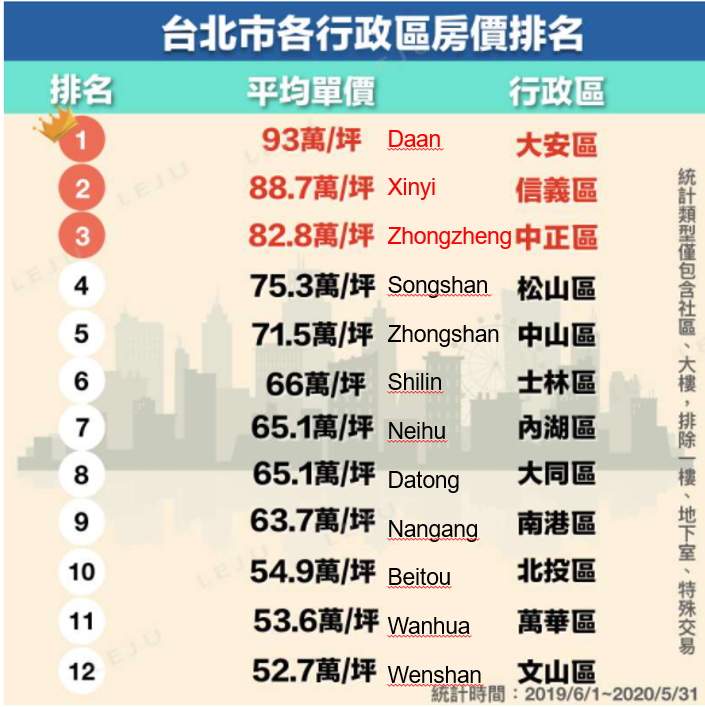

### Building age

Our result indicates that the older the house, the lower the price, which follows common sense. If we multiply the coefficient with span of feature "building age at transaction", this feature can influence around 90000 NTD in our model. This also indicates that age of house is a strong factor affecting housing price.

In [1027]:
Final_Gain_Table.loc[["building age at transaction"]]

,Coefficient,Coefficient_Normalized,P value
building age at transaction,-1280.031473,-90882.234552,0.0


### Building state

If we further analyze buidling state, we can see that apartment with less than 5 storey has most negative gain. In our case, building in this category are relatively low in height and has no elevator, thus it is not weird to get negative gains. The category 11storeyorgreater shows a positive gain, indicating that people still favors higher building with elevators than suite and low storey building. As for other kind of building state, there are too few data in our dataset, making it really hard to reflect the influence of those categories.

In [1028]:
#Load coefficient of location related features from coefficient table
Building_State = pd.DataFrame(columns = ["Building_State","Coefficient","P value"])
for index in list(Final_Gain_Table.index):
    if "building state" in index:
        Building_State = Building_State.append({"Building_State":index,"Coefficient":Final_Gain_Table.loc[index,"Coefficient"],"P value":Final_Gain_Table.loc[index,"P value"]}, ignore_index=True)

Building_State.sort_values(by = "Coefficient", ascending = False)


,Building_State,Coefficient,P value
0,building state_Apartment_11storeyorgreater,3374.645405,0.01794
2,building state_Suite,-7725.867314,0.02293
1,building state_Apartment_5storey,-15753.452323,0.00000


### Main building material

Main building material should take effect on housing price. However, in our dataset,  most of the data belongs to reinforced concrete while other categories only occupy very minor part. This kind of distribution makes the algorithm hard to detect the influence of each category. Therefore, we do not have good fitting model on main building material.

### Other 

Some of the factors that are considered to affect housing price does not have significant result in our analysis, or some features exhibit inverse behavior as what we expected. 

First thing is shifting area. Our shifting area feature are either rejected by correlation coefficient analysis or high P value (not significant). Perhaps area only affects total price but for unit price, the price does not necessarily increase as shifting area goes high.

Second is that the number of rooms has negative gain, which is quite opposite to what we have expected. But the magnitude of gain is relatively small.

Yet some features such as management organization and elevator does not seem to have significant response to our dependent variable.

In [1053]:
Other_Table = pd.DataFrame(columns = ["Coefficient","P value"])
Other_Table["Coefficient"] = LR_OLS_result.params[["management org","elevator","num_room","land shifting total area per unit transaction"]]
Other_Table["P value"] = LR_OLS_result.pvalues[["management org","elevator","num_room","land shifting total area per unit transaction"]]
Other_Table

,Coefficient,P value
management org,2349.673135,2.082335e-01
elevator,-2634.625968,7.282552e-01
num_room,-3742.583551,4.782910e-09
land shifting total area per unit transaction,36.942599,4.982231e-01


### Conclusion

After processing the raw data, we can finally build a predictive linear regression model with reasonable r square, RMSE and high reproducibility. From our model result, we found that location, age of building at transaction and building state are three major feature sets that would affect housing price in NTD per square meter within our range of interest.  

Unfortunately, some feature does not contain data with diversity or fine distribution, making it hard to capture the behavior of the feature.

## Reference
1. https://pip.moi.gov.tw/V3/E/SCRE0105.aspx
2. http://www.demographia.com/dhi.pdf
3. https://www.kaggle.com/chrischien17/taiwan-taipei-city-real-estate-transaction-records
4. https://plvr.land.moi.gov.tw/DownloadOpenData